# Hartbeespoort Dam – Hyacinth Coverage Prediction

This notebook is part of the AI module for the Hartbeespoort Dam project.  
Goal: build and document a complete ML workflow that:

1. Explores and visualises the hyacinth and water-quality data.
2. Trains and optimises at least one ML model to predict **hyacinth coverage (%)**.
3. Interprets the model and prepares it for deployment in the backend/dashboard.

> Dataset: zone-level, daily aggregates of water quality & weather features, with hyacinth coverage labels.


# 1. Imports & configuration

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import joblib
import os

!pip install missingno xgboost

try:
    import missingno as msno
except ImportError:
    msno = None
    print("missingno not installed - skipping missing data visualisations.")

try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None
    print("xgboost not installed - skipping XGBRegressor model.")
    
plt.style.use("default")
sns.set_theme()

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for missingno from https://files.pythonhosted.org/packages/87/22/cd5cf999af21c2f97486622c551ac3d07361ced8125121e907f588ff5f24/missingno-0.5.2-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


# 2. Load dataset

In [18]:
DATA_PATH = "data/hyacinth_zone_daily_sample.csv"  # adjust if needed

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (300, 18)


,date,zone_id,hyacinth_coverage_pct,hyacinth_status,avg_water_temp,avg_pH,avg_TDS,avg_turbidity,avg_DO,avg_air_temp,avg_humidity,total_rainfall,avg_wind_speed,coverage_yesterday,coverage_7_days_ago,rolling_avg_coverage_last_7_days,num_sensors_active,data_completeness_pct
0,2025-06-01,North,17.5,Good,23.31,6.13,162.2,19.63,8.65,27.75,75.5,9.44,2.39,17.5,17.5,17.48,2,96.98
1,2025-06-02,North,14.6,Good,27.22,6.47,151.2,6.82,8.55,17.22,57.6,4.03,17.92,17.5,14.6,16.02,1,86.29
2,2025-06-03,North,18.7,Good,25.09,7.82,149.9,23.47,8.78,19.58,43.1,5.80,3.22,14.6,18.7,16.93,2,92.49
3,2025-06-04,North,23.4,Good,22.96,6.21,191.3,14.83,7.08,32.67,53.0,2.44,7.13,18.7,23.4,18.54,2,82.20
4,2025-06-05,North,14.8,Good,22.28,6.85,263.6,43.73,5.03,25.21,56.7,4.44,2.40,23.4,14.8,17.80,4,84.88


## 3. Data overview

In this section we:
- Inspect column names and data types.
- Check basic statistics.
- Convert date columns to proper datetime types.
- Get a first impression of the value ranges.

In [ ]:
# Inspect structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              300 non-null    object 
 1   zone_id                           300 non-null    object 
 2   hyacinth_coverage_pct             300 non-null    float64
 3   hyacinth_status                   300 non-null    object 
 4   avg_water_temp                    300 non-null    float64
 5   avg_pH                            300 non-null    float64
 6   avg_TDS                           300 non-null    float64
 7   avg_turbidity                     300 non-null    float64
 8   avg_DO                            300 non-null    float64
 9   avg_air_temp                      300 non-null    float64
 10  avg_humidity                      300 non-null    float64
 11  total_rainfall                    300 non-null    float64
 12  avg_wind

In [ ]:
# Summary statistics for numeric & categorical columns
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,300,60,2025-06-01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zone_id,300,5,North,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hyacinth_coverage_pct,300.0,NaN,NaN,NaN,38.722333,13.331656,8.7,28.5,39.65,49.125,67.9
hyacinth_status,300,3,Warning,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_water_temp,300.0,NaN,NaN,NaN,25.190967,2.966651,20.0,22.5775,25.415,27.71,29.95
avg_pH,300.0,NaN,NaN,NaN,6.976533,0.565012,6.02,6.47,6.975,7.4425,8.0
avg_TDS,300.0,NaN,NaN,NaN,200.130333,54.282034,100.0,151.85,201.0,243.05,299.9
avg_turbidity,300.0,NaN,NaN,NaN,27.797033,12.282798,5.08,18.1375,28.55,38.0675,49.84
avg_DO,300.0,NaN,NaN,NaN,7.493367,1.378057,5.01,6.3775,7.59,8.65,9.98
avg_air_temp,300.0,NaN,NaN,NaN,24.7851,5.815369,15.11,19.9325,24.54,29.6725,34.91


In [21]:
# Convert `date` to datetime if not already
df["date"] = pd.to_datetime(df["date"])

# Sort by date just to be safe
df = df.sort_values(["zone_id", "date"]).reset_index(drop=True)

## 4. Missing data analysis

A clear understanding of missingness helps ensure preprocessing is well thought through. 

We visualise missing values and summarise them per column.


In [22]:
# Simple missing-value counts
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]


Series([], dtype: int64)

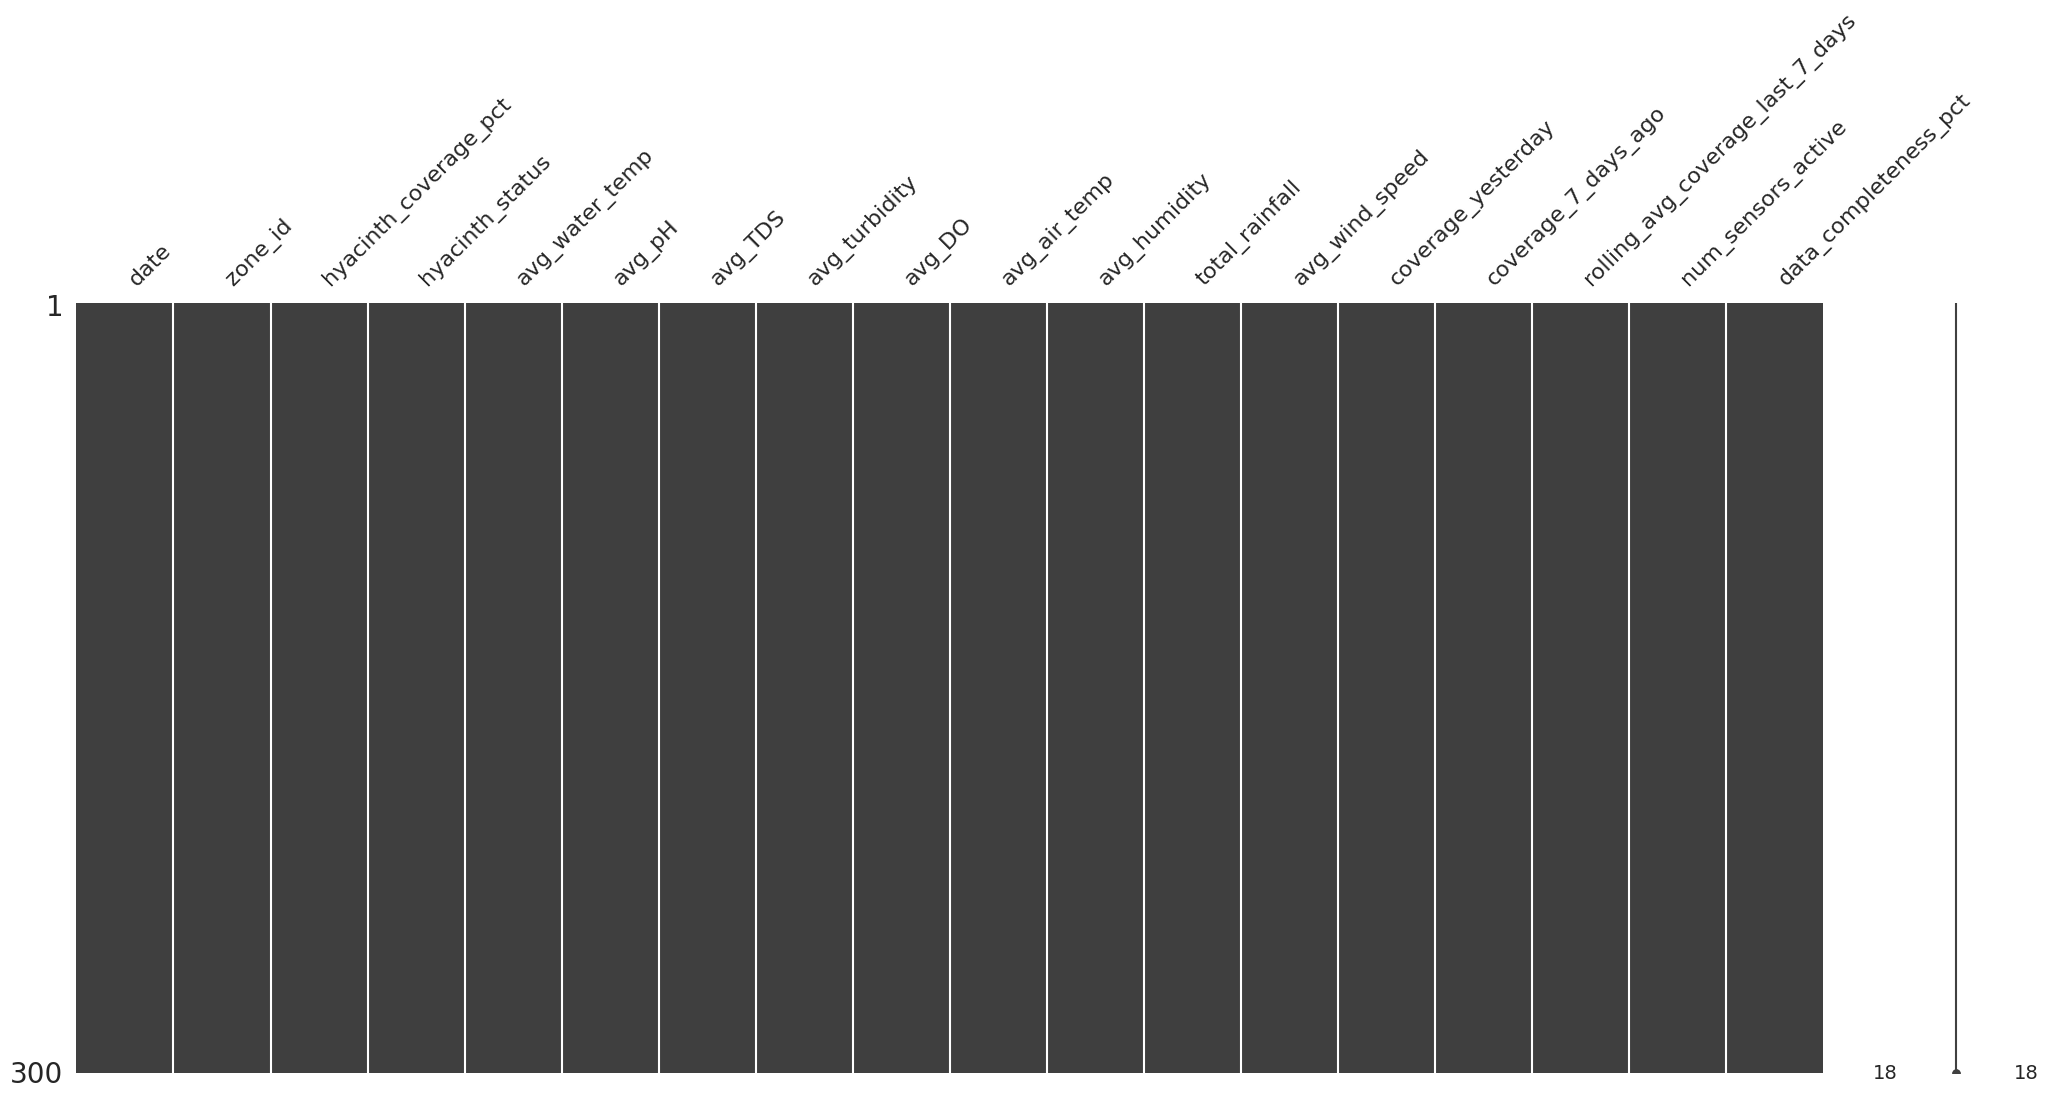

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


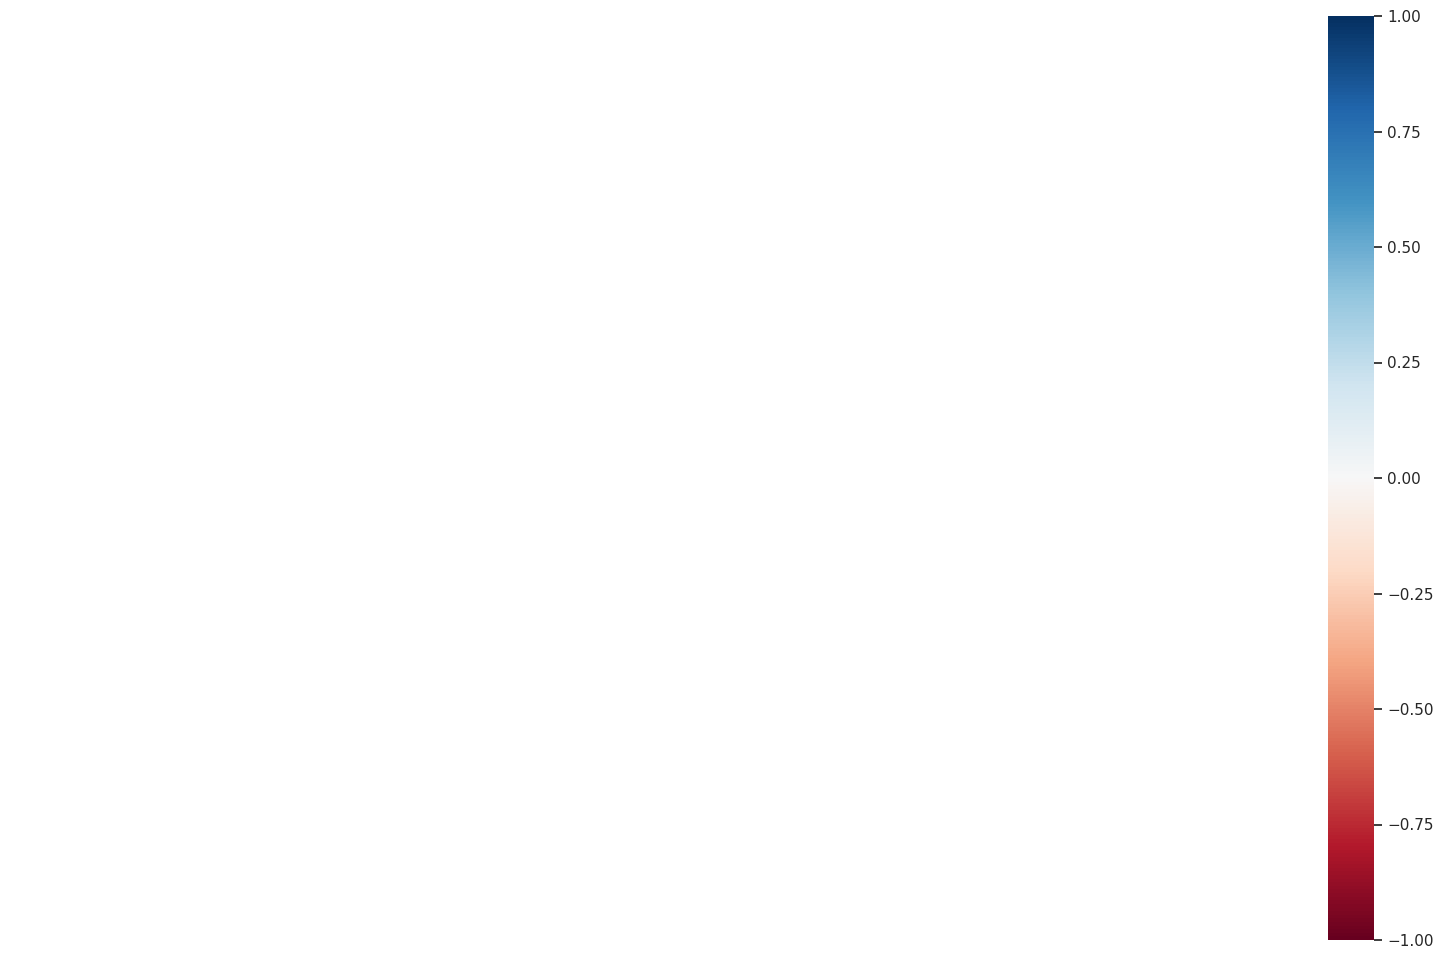

In [23]:
# Visual missing data patterns (if missingno is available)
if msno is not None:
    msno.matrix(df)
    plt.show()

    msno.heatmap(df)
    plt.show()
else:
    print("missingno not available - skipping visual missing-data plots.")


## 5. Univariate feature distributions

To understand the data, we inspect the distributions of all numeric features, including:
- Hyacinth coverage
- Water-quality parameters
- Weather features
- Engineered lag features


In [24]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
len(numeric_cols), numeric_cols


(15,
 Index(['hyacinth_coverage_pct', 'avg_water_temp', 'avg_pH', 'avg_TDS',
        'avg_turbidity', 'avg_DO', 'avg_air_temp', 'avg_humidity',
        'total_rainfall', 'avg_wind_speed', 'coverage_yesterday',
        'coverage_7_days_ago', 'rolling_avg_coverage_last_7_days',
        'num_sensors_active', 'data_completeness_pct'],
       dtype='object'))

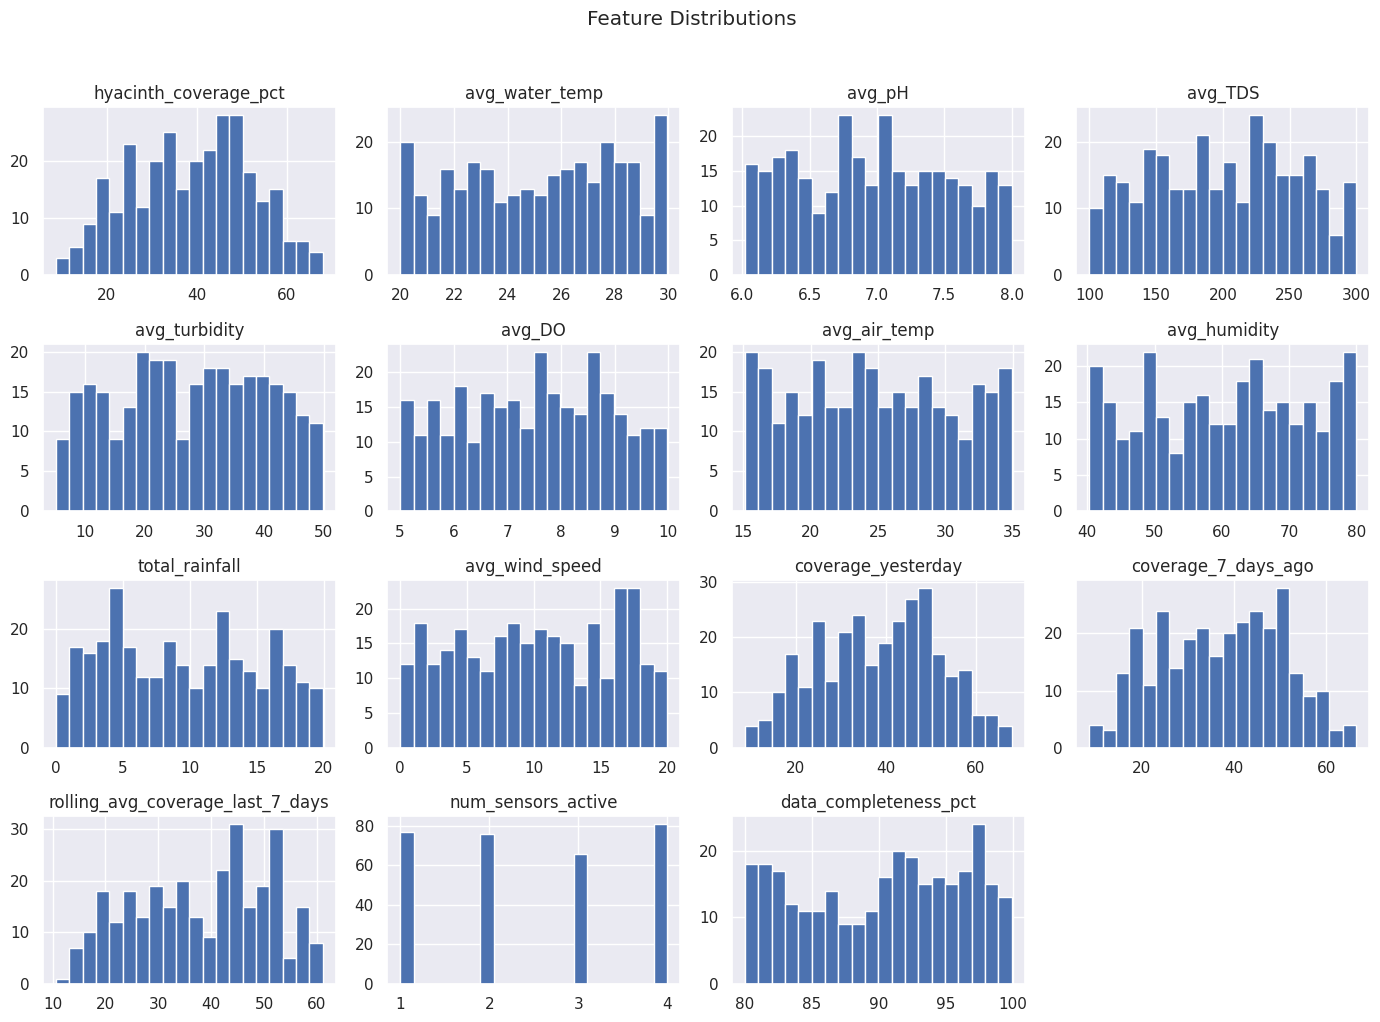

In [25]:
# Histograms for all numeric features
df[numeric_cols].hist(figsize=(14, 10), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


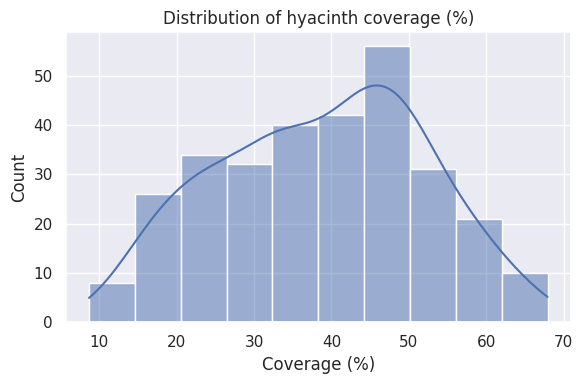

In [26]:
# Focused look at coverage distribution
plt.figure(figsize=(6,4))
sns.histplot(df["hyacinth_coverage_pct"], kde=True)
plt.title("Distribution of hyacinth coverage (%)")
plt.xlabel("Coverage (%)")
plt.tight_layout()
plt.show()


## 6. Zone-level patterns and time series

We look at:
- Hyacinth coverage over time per zone.
- Zone-wise distribution using boxplots.
- 7-day rolling mean to smooth short-term fluctuations.


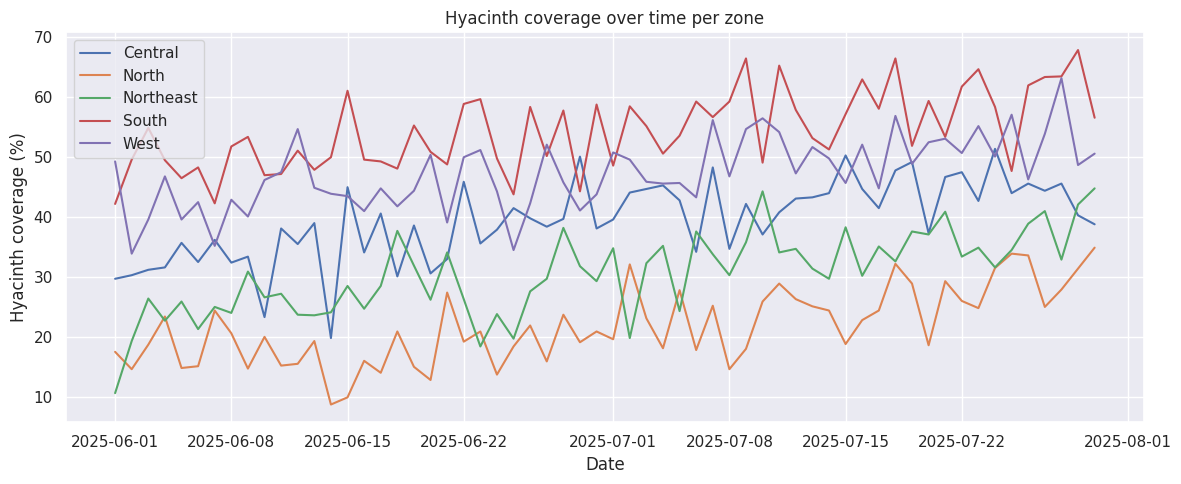

In [ ]:
# Time series per zone
plt.figure(figsize=(12, 5))
for zone, sub in df.groupby("zone_id"):
    plt.plot(sub["date"], sub["hyacinth_coverage_pct"], label=zone)

plt.xlabel("Date")
plt.ylabel("Hyacinth coverage (%)")
plt.title("Hyacinth coverage over time per zone")
plt.legend()
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


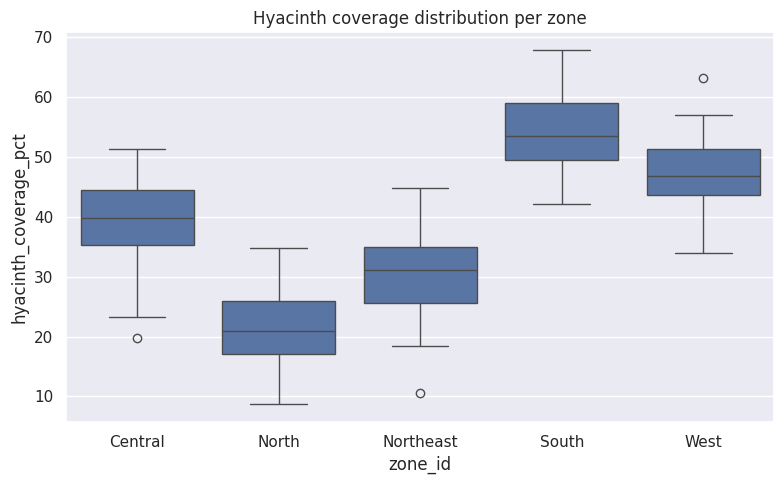

In [28]:
# Boxplot: coverage per zone
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="zone_id", y="hyacinth_coverage_pct")
plt.title("Hyacinth coverage distribution per zone")
plt.tight_layout()
plt.show()


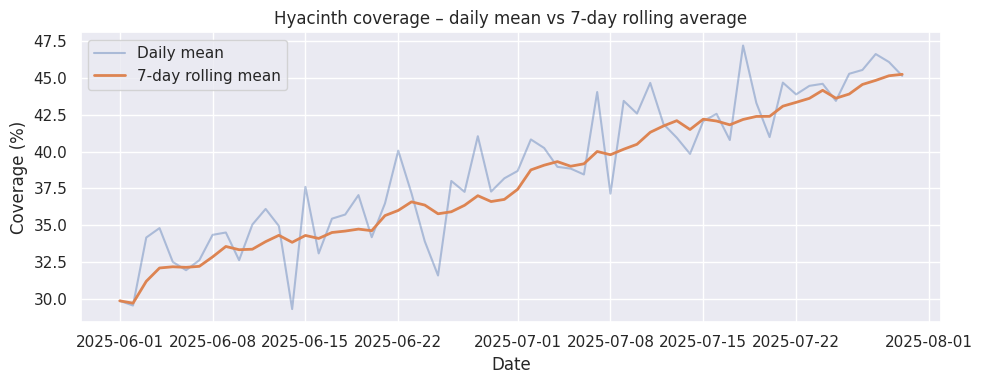

In [29]:
# 7-day rolling average across all zones
daily_mean = df.groupby("date")["hyacinth_coverage_pct"].mean()
rolling = daily_mean.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(daily_mean.index, daily_mean.values, alpha=0.4, label="Daily mean")
plt.plot(rolling.index, rolling.values, label="7-day rolling mean", linewidth=2)
plt.title("Hyacinth coverage – daily mean vs 7-day rolling average")
plt.xlabel("Date")
plt.ylabel("Coverage (%)")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Relationships between features and hyacinth coverage

We now explore how key features relate to the target variable using scatterplots and correlations.


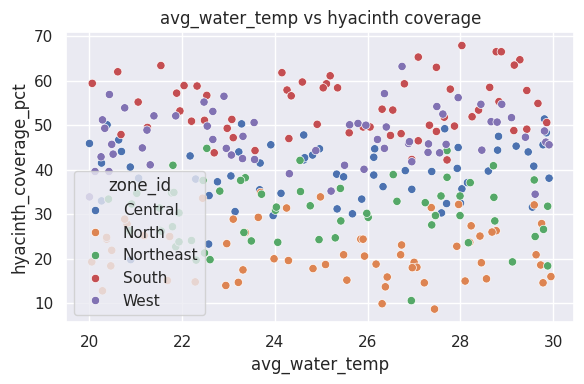

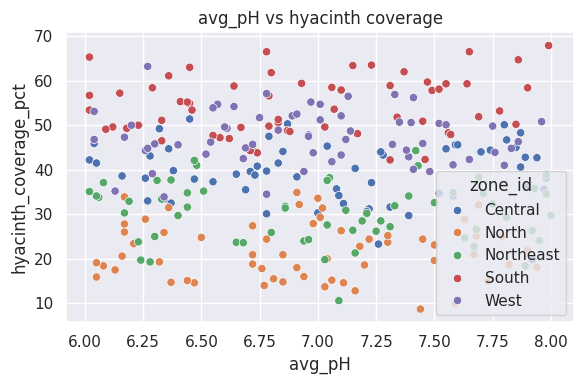

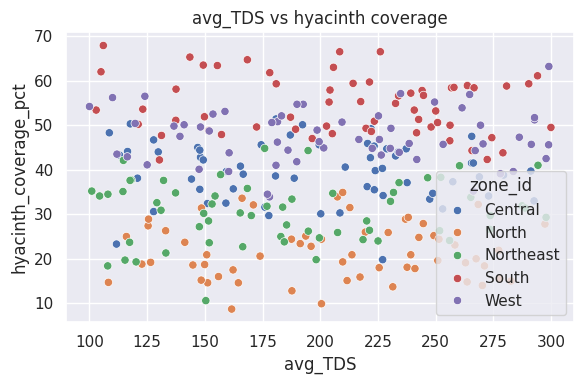

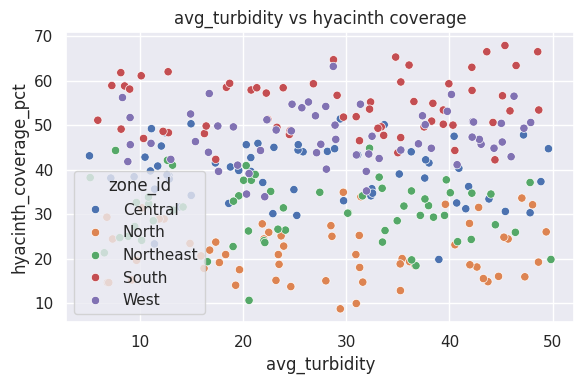

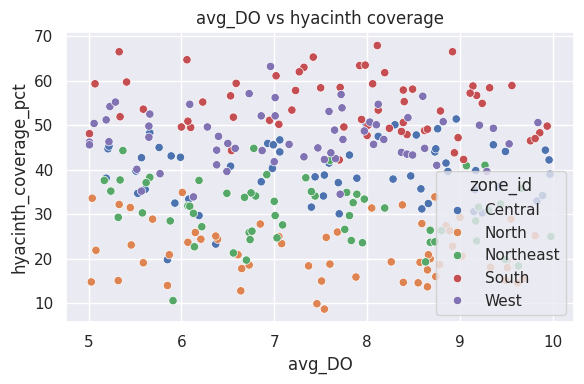

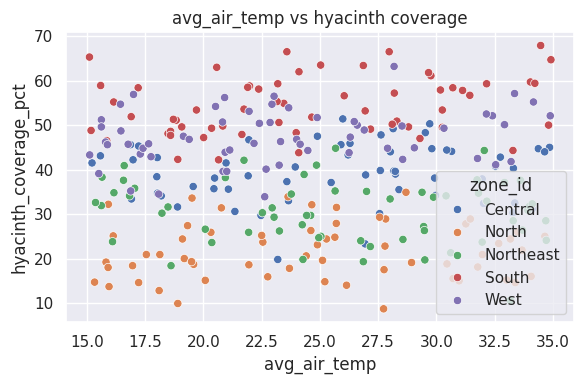

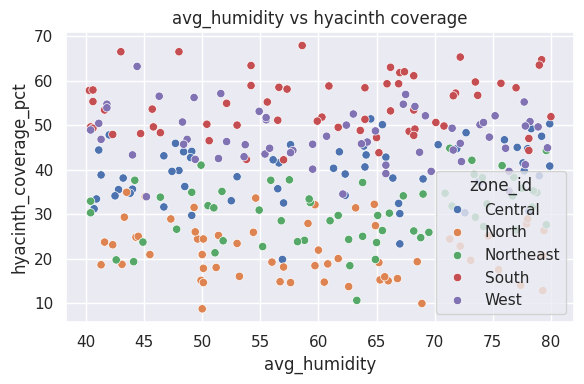

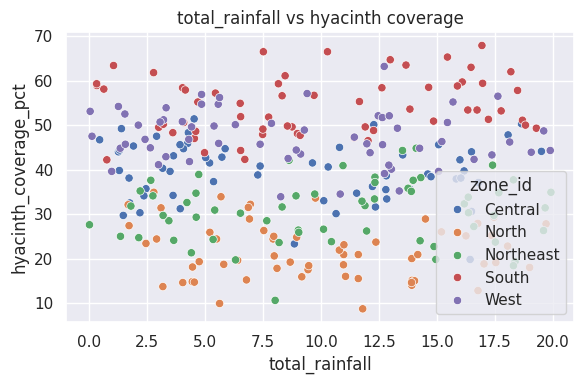

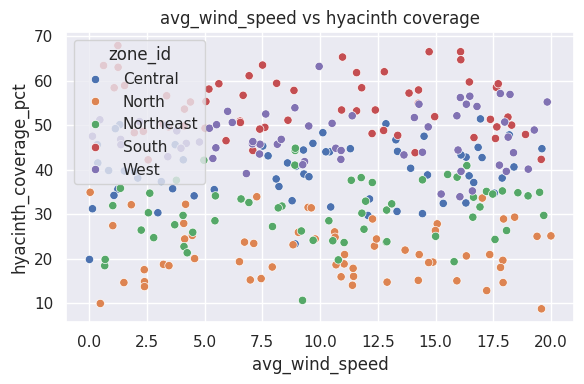

In [30]:
key_features = [
    "avg_water_temp",
    "avg_pH",
    "avg_TDS",
    "avg_turbidity",
    "avg_DO",
    "avg_air_temp",
    "avg_humidity",
    "total_rainfall",
    "avg_wind_speed",
]

for f in key_features:
    if f in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=df, x=f, y="hyacinth_coverage_pct", hue="zone_id")
        plt.title(f"{f} vs hyacinth coverage")
        plt.tight_layout()
        plt.show()


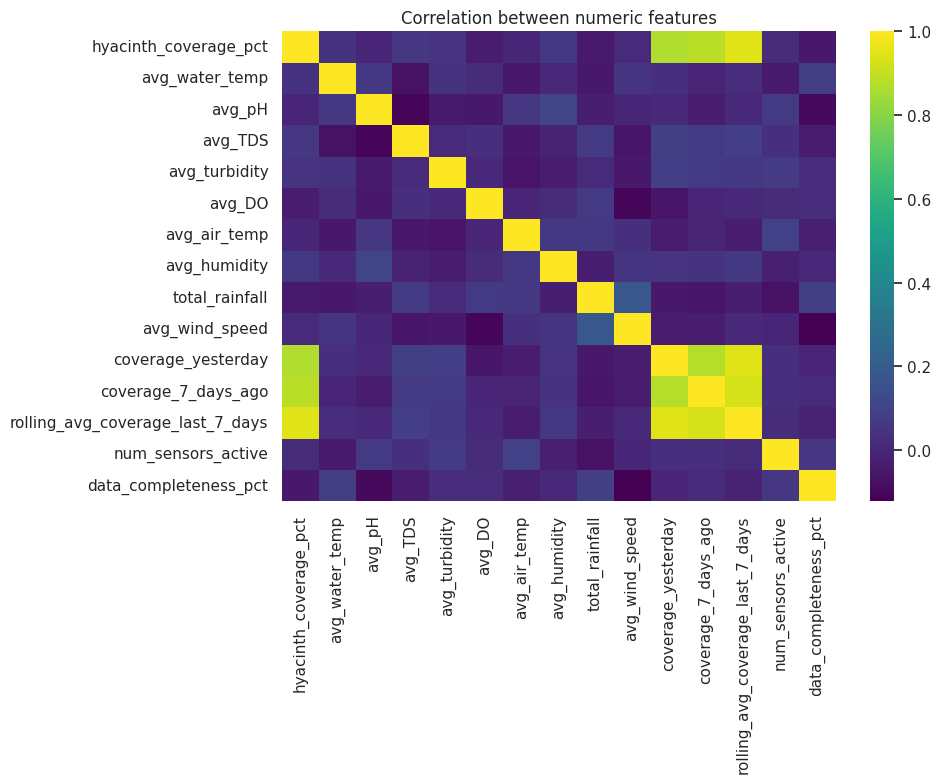

In [31]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Correlation between numeric features")
plt.tight_layout()
plt.show()


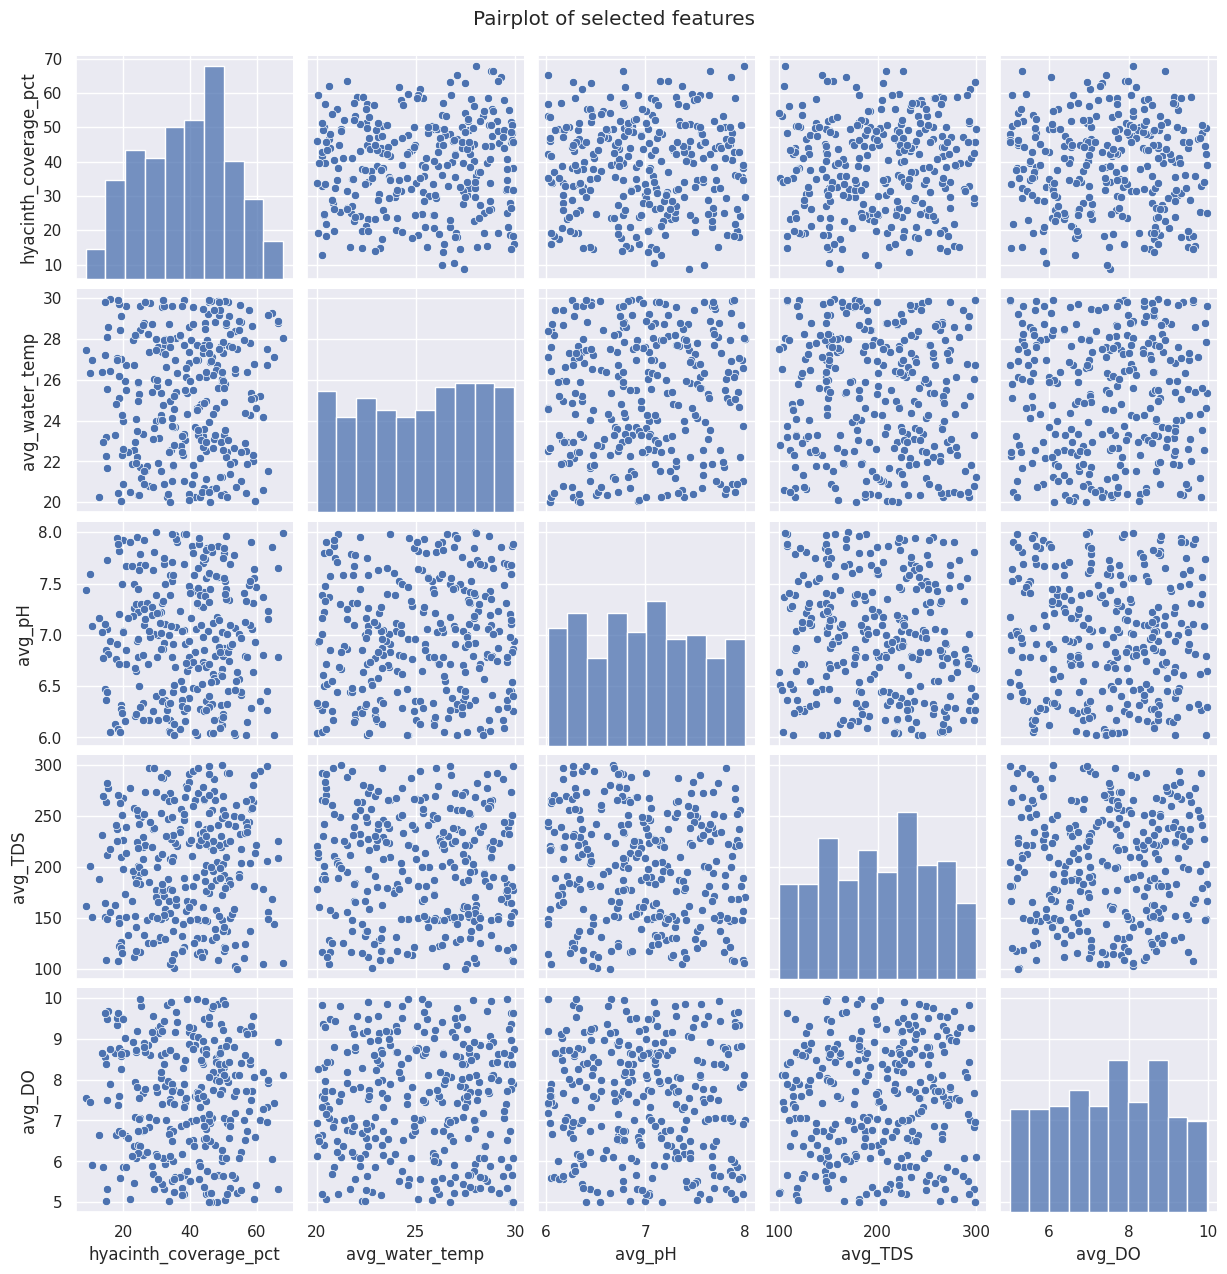

In [32]:
# Optional: pairplot (can be slow if dataset is large)
subset_cols = [
    "hyacinth_coverage_pct",
    "avg_water_temp",
    "avg_pH",
    "avg_TDS",
    "avg_DO",
]
sns.pairplot(df[subset_cols])
plt.suptitle("Pairplot of selected features", y=1.02)
plt.show()


## 8. Feature engineering and modelling dataset

We:
- Extract calendar features from `date` (month, day of year).
- One-hot encode `zone_id`.
- Drop target-leak or non-feature columns.
- Define **X** (features) and **y** (target).


In [33]:
df_model = df.copy()

# Calendar features
df_model["month"] = df_model["date"].dt.month
df_model["day_of_year"] = df_model["date"].dt.dayofyear

# One-hot encode zone
df_model = pd.get_dummies(df_model, columns=["zone_id"], drop_first=True)

# Target and drop columns
target_col = "hyacinth_coverage_pct"
drop_cols = ["hyacinth_status", "date"]  # status is derived from coverage

X = df_model.drop(columns=[target_col] + drop_cols)
y = df_model[target_col]

print("Feature matrix shape:", X.shape)
X.head()


Feature matrix shape: (300, 20)


,avg_water_temp,avg_pH,avg_TDS,avg_turbidity,avg_DO,avg_air_temp,avg_humidity,total_rainfall,avg_wind_speed,coverage_yesterday,coverage_7_days_ago,rolling_avg_coverage_last_7_days,num_sensors_active,data_completeness_pct,month,day_of_year,zone_id_North,zone_id_Northeast,zone_id_South,zone_id_West
0,23.96,7.39,177.7,25.19,6.19,22.47,49.1,1.46,12.07,29.7,29.7,29.70,2,92.85,6,152,False,False,False,False
1,27.59,7.00,208.5,47.82,9.24,33.28,72.6,2.18,2.98,29.7,30.3,29.99,4,91.60,6,153,False,False,False,False
2,25.34,7.22,253.0,41.58,8.59,34.11,40.7,3.92,0.15,30.3,31.2,30.38,3,81.43,6,154,False,False,False,False
3,29.55,7.31,176.0,13.87,7.40,18.89,46.7,12.35,10.46,31.2,31.6,30.68,2,86.15,6,155,False,False,False,False
4,28.03,7.08,162.3,32.47,8.58,20.45,56.5,2.44,3.62,31.6,35.7,31.67,3,97.19,6,156,False,False,False,False


## 9. Train/validation split and baseline

We split the data into training and validation sets and start with a **DummyRegressor** as a baseline.
This helps us see if our real models actually learn something useful.


In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape


((240, 20), (60, 20))

In [35]:
# Baseline dummy model: always predicts training mean
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
r2_dummy = r2_score(y_val, y_pred_dummy)

print(f"Dummy baseline - MAE: {mae_dummy:.2f}, R²: {r2_dummy:.3f}")


Dummy baseline - MAE: 13.75, R²: -0.005


## 10. Candidate models

We compare several algorithms:

- Linear Regression
- Random Forest
- (Optional) XGBoost

This provides a more "detailed implementation of at least 1 ML technique" and allows us to justify why we pick our final model.


In [36]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
}

if XGBRegressor is not None:
    models["XGBoost"] = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
    )

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results[name] = {"MAE": mae, "R2": r2}

results_df = pd.DataFrame(results).T.sort_values("MAE")
results_df


,MAE,R2
LinearRegression,3.512388,0.918831
RandomForest,4.212842,0.884318
XGBoost,4.539416,0.872504


## 11. Hyperparameter tuning for the chosen model (Random Forest)

We refine the Random Forest model using `GridSearchCV` to systematically explore combinations of parameters.


In [37]:
# Parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    rf_base,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MAE:", -grid.best_score_)

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_val)
mae_best = mean_absolute_error(y_val, y_pred_best)
r2_best = r2_score(y_val, y_pred_best)

print(f"Validation - MAE: {mae_best:.2f}, R²: {r2_best:.3f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}
Best CV MAE: 3.773122707100701
Validation - MAE: 4.15, R²: 0.888


## 12. Model interpretation & diagnostics

We now:
- Visualise **actual vs predicted** coverage.
- Inspect the **error distribution**.
- Look at **feature importances** for the Random Forest model.


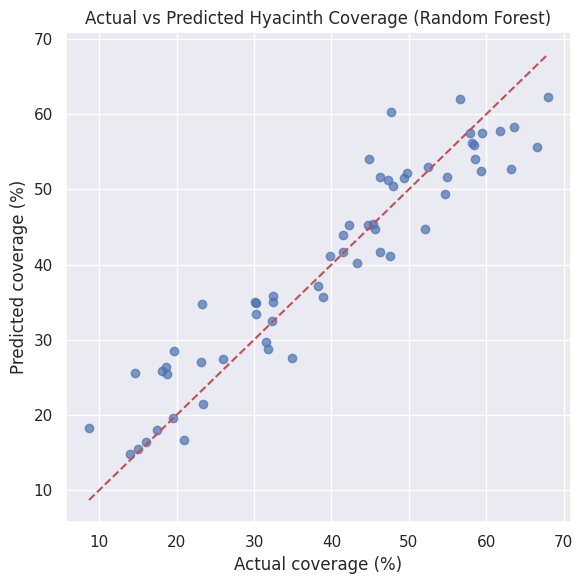

In [38]:
# Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_best, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual coverage (%)")
plt.ylabel("Predicted coverage (%)")
plt.title("Actual vs Predicted Hyacinth Coverage (Random Forest)")
plt.tight_layout()
plt.show()


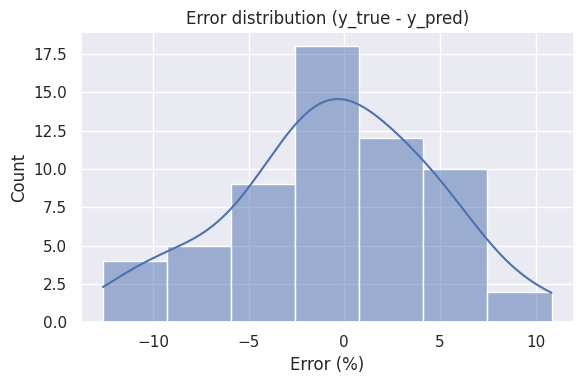

In [39]:
# Error distribution
errors = y_val - y_pred_best

plt.figure(figsize=(6,4))
sns.histplot(errors, kde=True)
plt.title("Error distribution (y_true - y_pred)")
plt.xlabel("Error (%)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


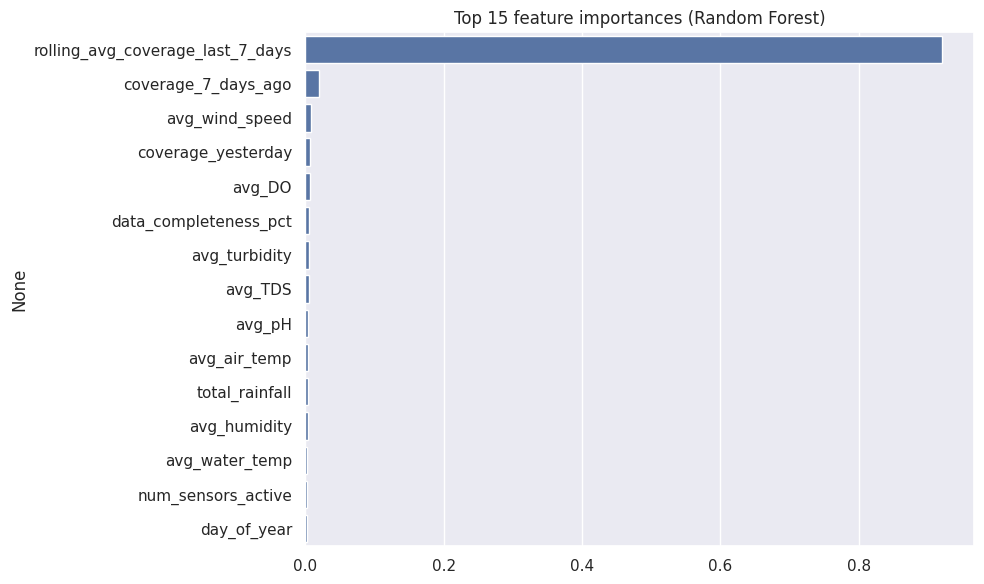

rolling_avg_coverage_last_7_days    0.920789
coverage_7_days_ago                 0.020435
avg_wind_speed                      0.008080
coverage_yesterday                  0.006672
avg_DO                              0.006306
data_completeness_pct               0.005421
avg_turbidity                       0.004916
avg_TDS                             0.004738
avg_pH                              0.004225
avg_air_temp                        0.003974
total_rainfall                      0.003931
avg_humidity                        0.003286
avg_water_temp                      0.002806
num_sensors_active                  0.002242
day_of_year                         0.001954
zone_id_Northeast                   0.000084
month                               0.000076
zone_id_North                       0.000032
zone_id_West                        0.000027
zone_id_South                       0.000007
dtype: float64

In [40]:
# Feature importances
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances_sorted.values[:15], y=importances_sorted.index[:15])
plt.title("Top 15 feature importances (Random Forest)")
plt.tight_layout()
plt.show()

importances_sorted.head(20)


## 13. Save trained model for deployment

We persist the final optimised model to disk so the backend can load it and serve predictions to the dashboard.


In [41]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "hyacinth_rf_model.joblib")
joblib.dump(best_model, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


Model saved to models/hyacinth_rf_model.joblib


## 14. Helper prediction function

This function mimics how the backend will call the model.  
It accepts a single **feature dictionary**, ensures correct column order, and returns a numeric prediction.


In [42]:
def predict_coverage(sample_dict, model=best_model, feature_template=X.columns):
    """
    Predict hyacinth coverage for a single sample.
    
    Parameters
    ----------
    sample_dict : dict
        Dictionary mapping feature names to values.
    model : fitted model
    feature_template : Index
        Feature columns used during training (X.columns).
    """
    sample_df = pd.DataFrame([sample_dict])
    
    # Add any missing columns as 0
    for col in feature_template:
        if col not in sample_df.columns:
            sample_df[col] = 0

    # Keep column order consistent
    sample_df = sample_df[feature_template]

    return float(model.predict(sample_df)[0])

# Example usage on an existing validation sample
example = X_val.iloc[0].to_dict()
pred_example = predict_coverage(example)
actual_example = float(y_val.iloc[0])

print("Example prediction:", pred_example)
print("Actual value:      ", actual_example)


Example prediction: 52.158680475548344
Actual value:       49.8


## 15. Conclusions & next steps

**Data exploration & preprocessing**

- We explored distributions of all numeric features.
- We visualised hyacinth coverage over time per zone and via rolling means.
- We analysed relationships between coverage and key water-quality parameters.
- Missing data checks and visualisations (via `missingno`) helped verify data completeness.

**Model training & optimisation**

- Baseline `DummyRegressor` established a reference MAE and R².
- We compared several models (Linear Regression, Random Forest, [optional] XGBoost).
- Random Forest with hyperparameter tuning achieved the best performance on the validation set.
- Error plots and actual-vs-predicted graphs showed where the model performs well and where it struggles.
- Feature importance analysis provided interpretable insights about which variables drive hyacinth coverage.

**Next steps**

- Replace the synthetic dataset with the real Hartbeespoort Dam data from sensors + external sources.
- Re-run the notebook and adjust feature engineering to include additional parameters (nutrients, satellite indices, etc.).
- Integrate the saved model into the backend API so the dashboard can:
  - Request predictions per zone and date.
  - Display predicted coverage & risk levels (Good / Warning / Critical).
